In [1]:
# Code below adapted from:
# https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/linear_decoder.html
# Background: 
# https://www.nxn.se/valent/2020/9/16/a-trip-through-the-layers-of-scvi

In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import torch
# import pytorch_lightning as pl

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

scvi.settings.seed = 0
print(scvi.__version__)

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


1.0.4


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

# Model configuration parameters
n_layers=1        # default == 1
n_hidden=128      # default == 128
n_latent=4        # default == 10
max_epochs=250    # 250 in paper
lr=5e-3           # 5e-3 in paper
eval_every_n_epoch=10
random_seed=42    # for scanpy

In [4]:
os.chdir('/mnt/d/ldVAE')

In [6]:
adata_path = "/mnt/d/ldVAE/selPerez.h5ad"
adata = sc.read_h5ad(adata_path)

In [7]:
adata.layers["counts"] = adata.X.copy()  # Keep original

In [8]:
# Pseudocounts because scVI requires counts:
adata.layers["counts"] = adata.layers["counts"]**2
# adata.layers["counts"]= adata.layers["counts"] * 100
adata.layers["counts"]= adata.layers["counts"] * 10

adata.layers["counts"] = adata.layers["counts"].round().astype(int)

Text(0, 0.5, 'Frequency')

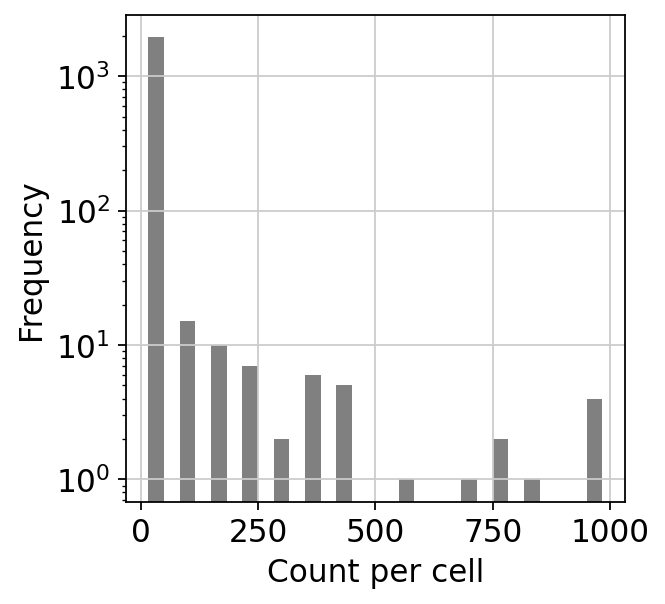

In [9]:
# Check ditribution of pesudocounts for an example gene:
fig = plt.figure(figsize=(4,4))

plt.yscale("log")  
plt.hist(adata.layers["counts"][48, :], bins=15, rwidth=0.5, color="gray")
plt.xlabel("Count per cell")
plt.ylabel("Frequency")

In [10]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts") 
model = scvi.model.LinearSCVI(adata, 
                              n_hidden=n_hidden, 
                              n_latent=n_latent,
                              n_layers=n_layers) 

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.



In [11]:
model.train(max_epochs=max_epochs, plan_kwargs={"lr":lr},
            check_val_every_n_epoch=eval_every_n_epoch, 
            accelerator="gpu", 
            train_size=0.9)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████████████████████| 250/250 [2:26:00<00:00, 35.43s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.02e+3]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████████████████████| 250/250 [2:26:00<00:00, 35.04s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.02e+3]


<Figure size 900x900 with 0 Axes>

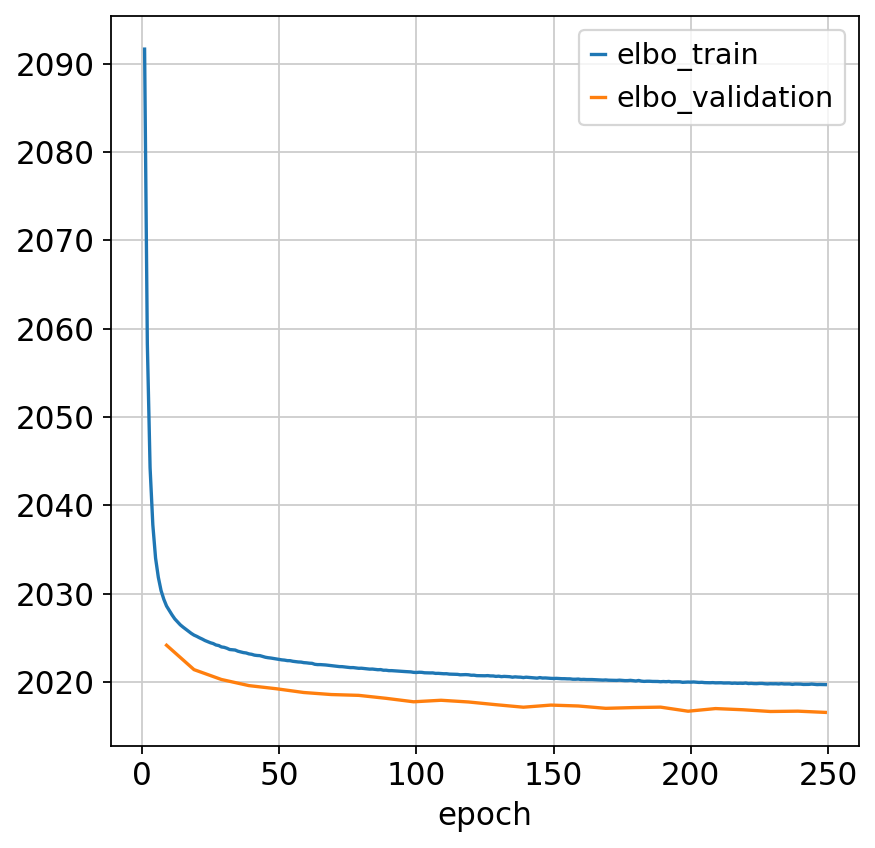

In [12]:
fig = plt.figure(figsize=(6, 6), dpi=150)

train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

plt.savefig('/mnt/d/scGPT/ldVAE/figures/Perez_training_curve.png')
plt.show()

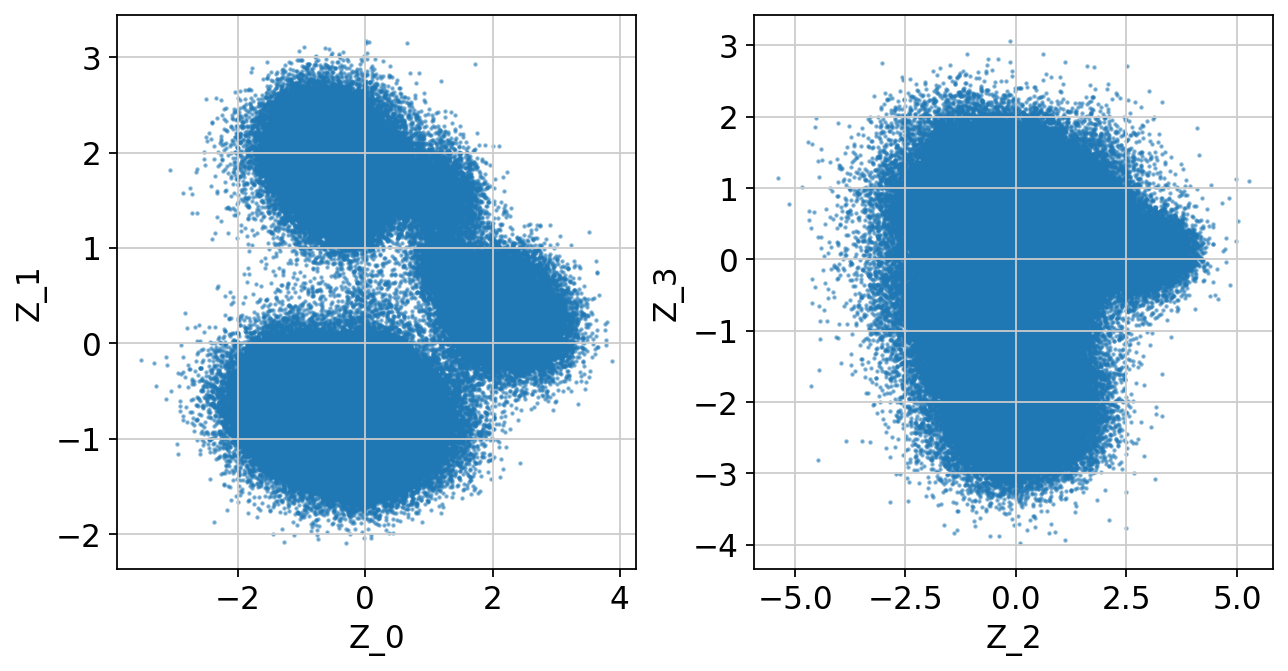

In [14]:
#### Extract latent dims:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z


#### Plot
fig = plt.figure(figsize=(12, 12))

N = Z_hat.shape[1] - 1
for f in range(0, N, 2):
    plt.subplot(3, 3, int(f / 2) + 1)
    
    plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], 
                marker=".", s=4, alpha = 0.5)
    
    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")


# plt.subplot(3, 3, 8)
# plt.scatter(adata.obs[f"Z_{f+1}"], adata.obs[f"Z_{f + 2}"], 
#             marker=".", s=4, alpha=0.5)
# plt.xlabel(f"Z_{f + 1}")
# plt.ylabel(f"Z_{f + 2}")

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('/mnt/d/scGPT/ldVAE/figures/paired_Z_scatterplots.png', dpi=150)
plt.show()

In [15]:
loadings = model.get_loadings()
loadings.head()


print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	ASCL2, -0.81	C1orf21, -0.74	S1PR5, -0.73	MIR4435-1HG, -0.73	CES1, -0.71
	...
	OSBPL10-AS1, 1.5	AFF3, 1.6	CD22, 1.6	FCER2, 1.7	COBLL1, 1.8
---------------------------------------------------------------------------------------

Z_1:	CTC-523E23.11, -2.0	SIDT1-AS1, -1.9	GPR171, -1.9	RP11-291B21.2, -1.8	CD40LG, -1.8
	...
	CTB-61M7.2, 0.9	ARHGAP24, 0.96	CCR1, 1.1	FAM198B, 1.1	BASP1, 1.3
---------------------------------------------------------------------------------------

Z_2:	FOLR3, -0.57	THBS1, -0.54	CES1, -0.51	QPCT, -0.5	EREG, -0.47
	...
	CX3CR1, 1.0	HERC5, 1.4	IFIT2, 1.5	IFIT3, 1.5	HES4, 1.7
---------------------------------------------------------------------------------------

Z_3:	C1orf21, -1.1	S1PR5, -1.0	CD160, -1.0	KLRC1, -0.9	FCRL6, -0.89
	...
	LEF1, 1.2	FHIT, 1.2	PASK, 1.3	MAL, 1.3	TSHZ2, 1.5
-------------------------------------------------------------------

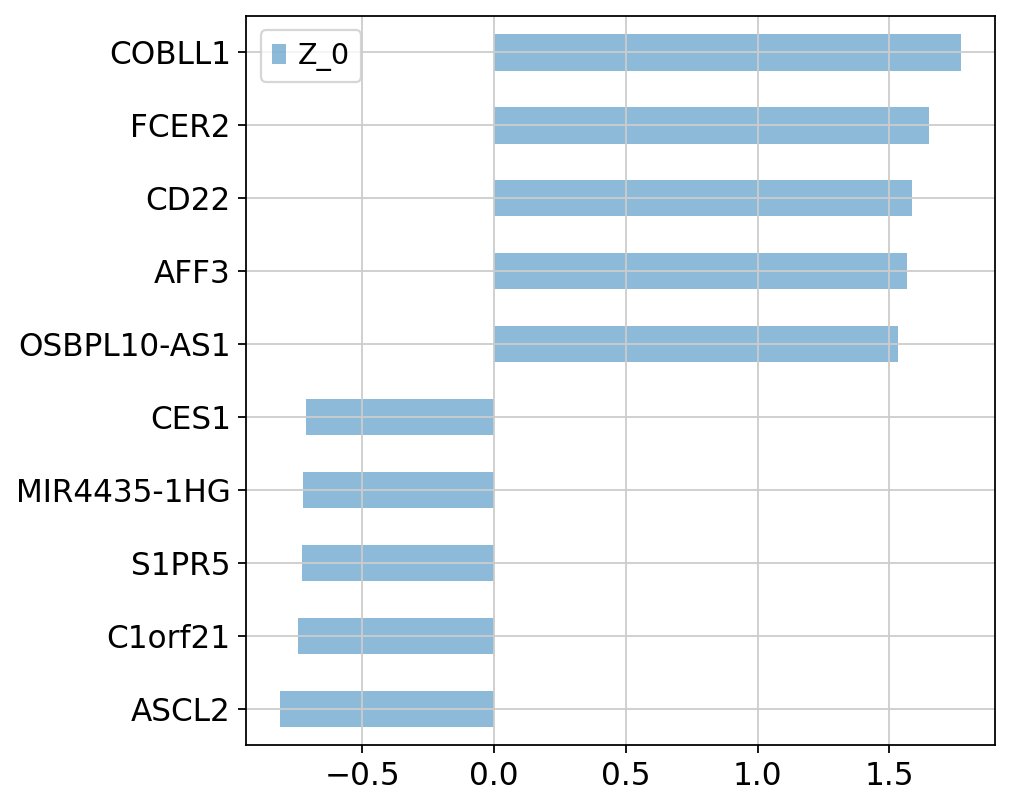

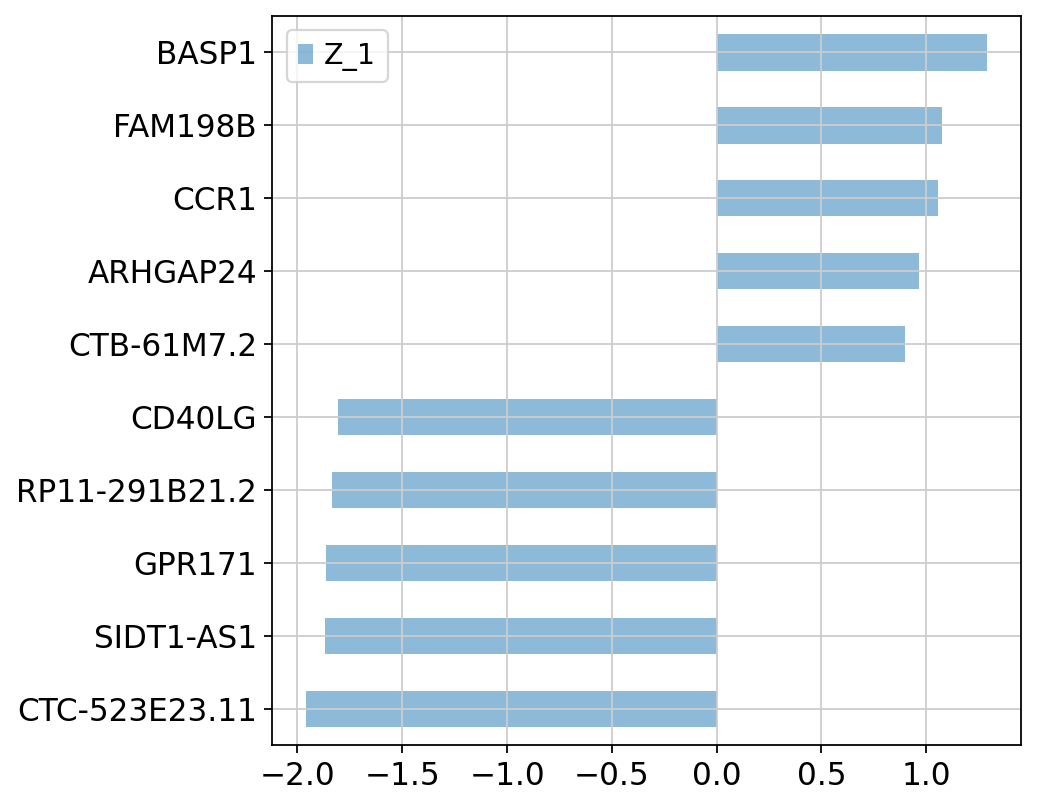

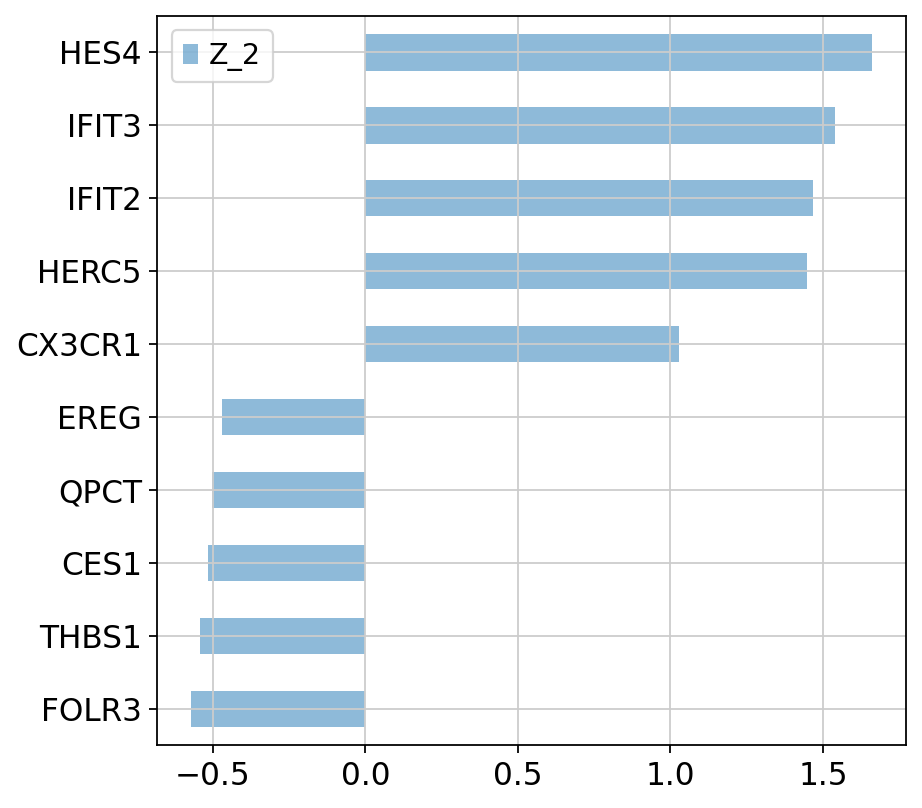

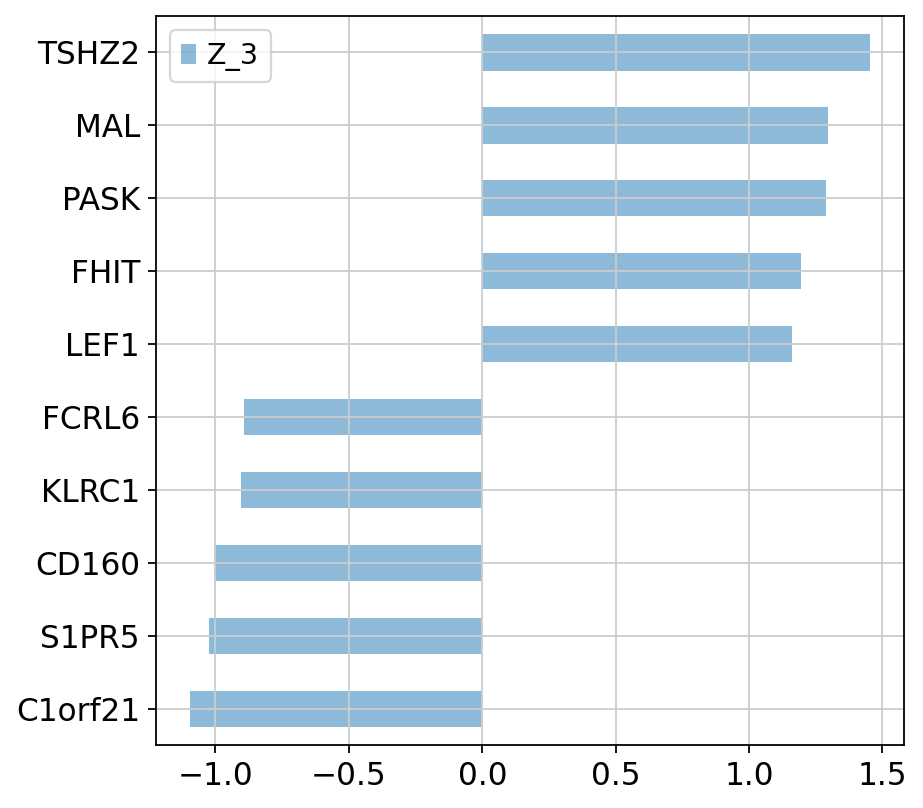

In [16]:
from matplotlib.backends.backend_pdf import PdfPages

pdfFile = PdfPages("/mnt/d/scGPT/ldVAE/figures/Z_genes_barplots.pdf")

for colNo in range(loadings.shape[1]):
    loading_ = loadings.iloc[:, colNo].sort_values()
    df1 = loading_.head(5).rename({0:""}).to_frame().T
    df2 = loading_.tail(5).rename({0:""}).to_frame().T
    df = df1.join(df2)   

    fig, ax = plt.subplots()
    df.T.plot.barh(alpha=0.5, ax=ax)     
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=(1.1, 1))   
    
    pdfFile.savefig(fig)


pdfFile.close()

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


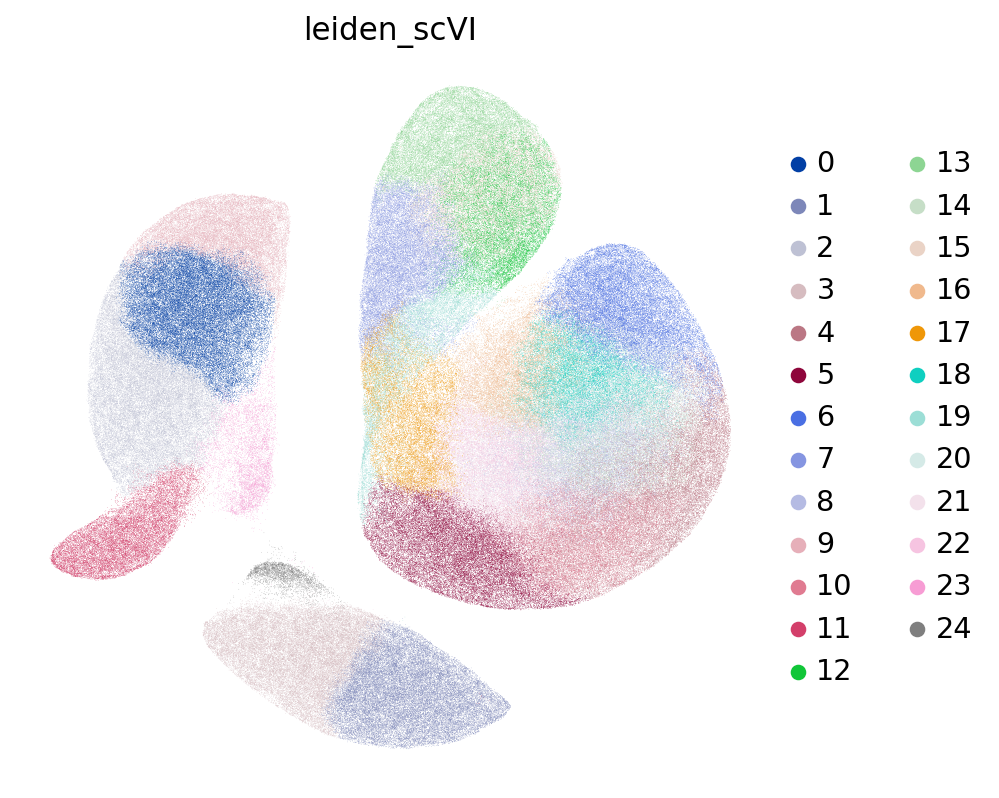

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


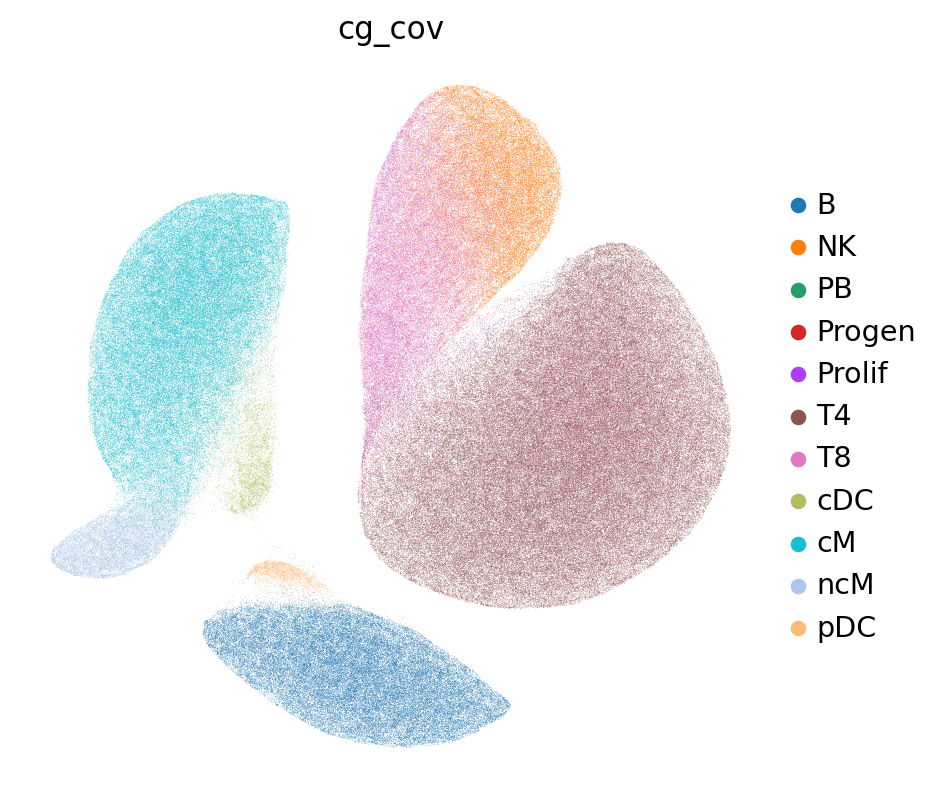

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


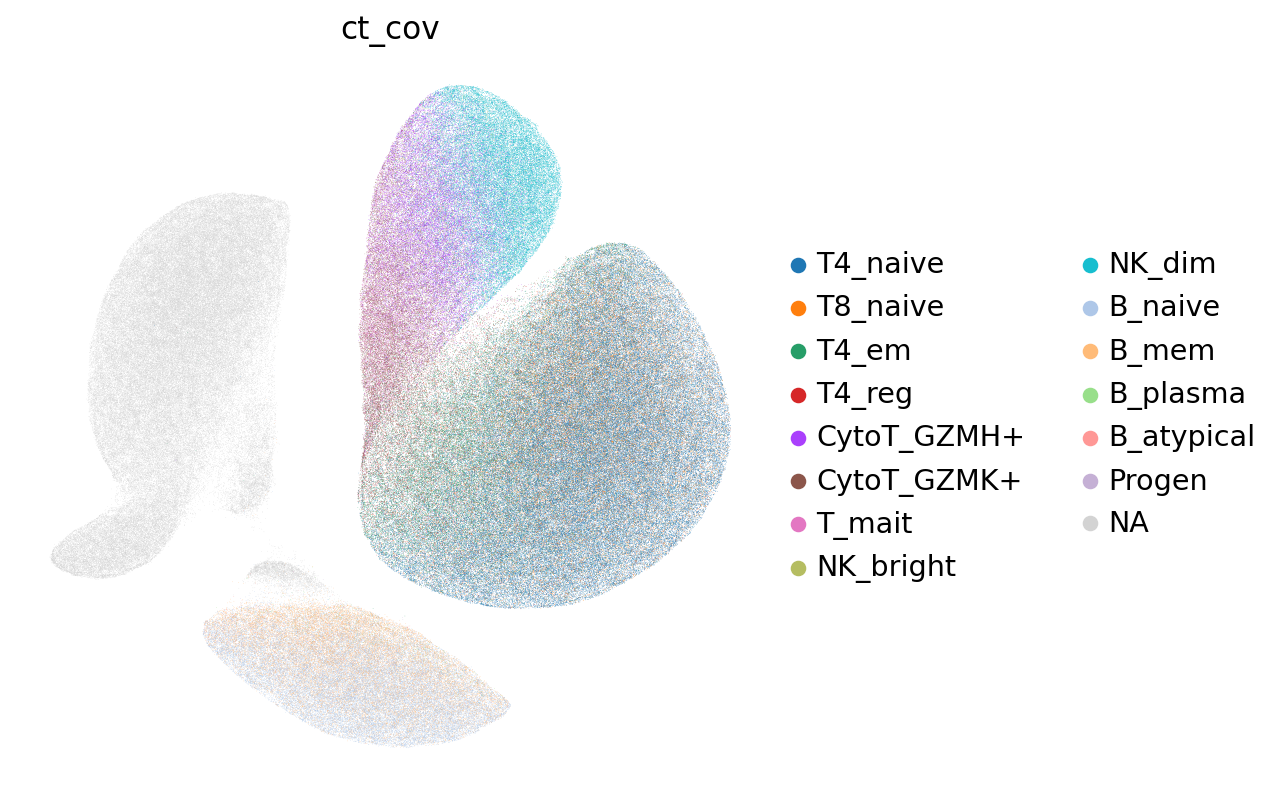

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


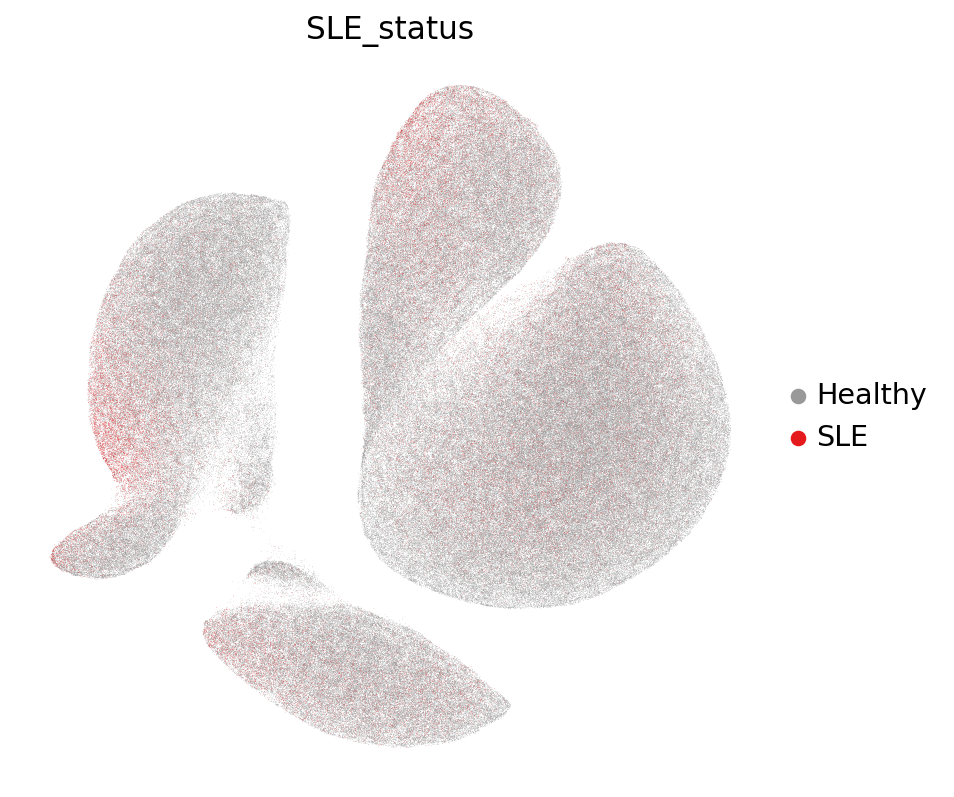

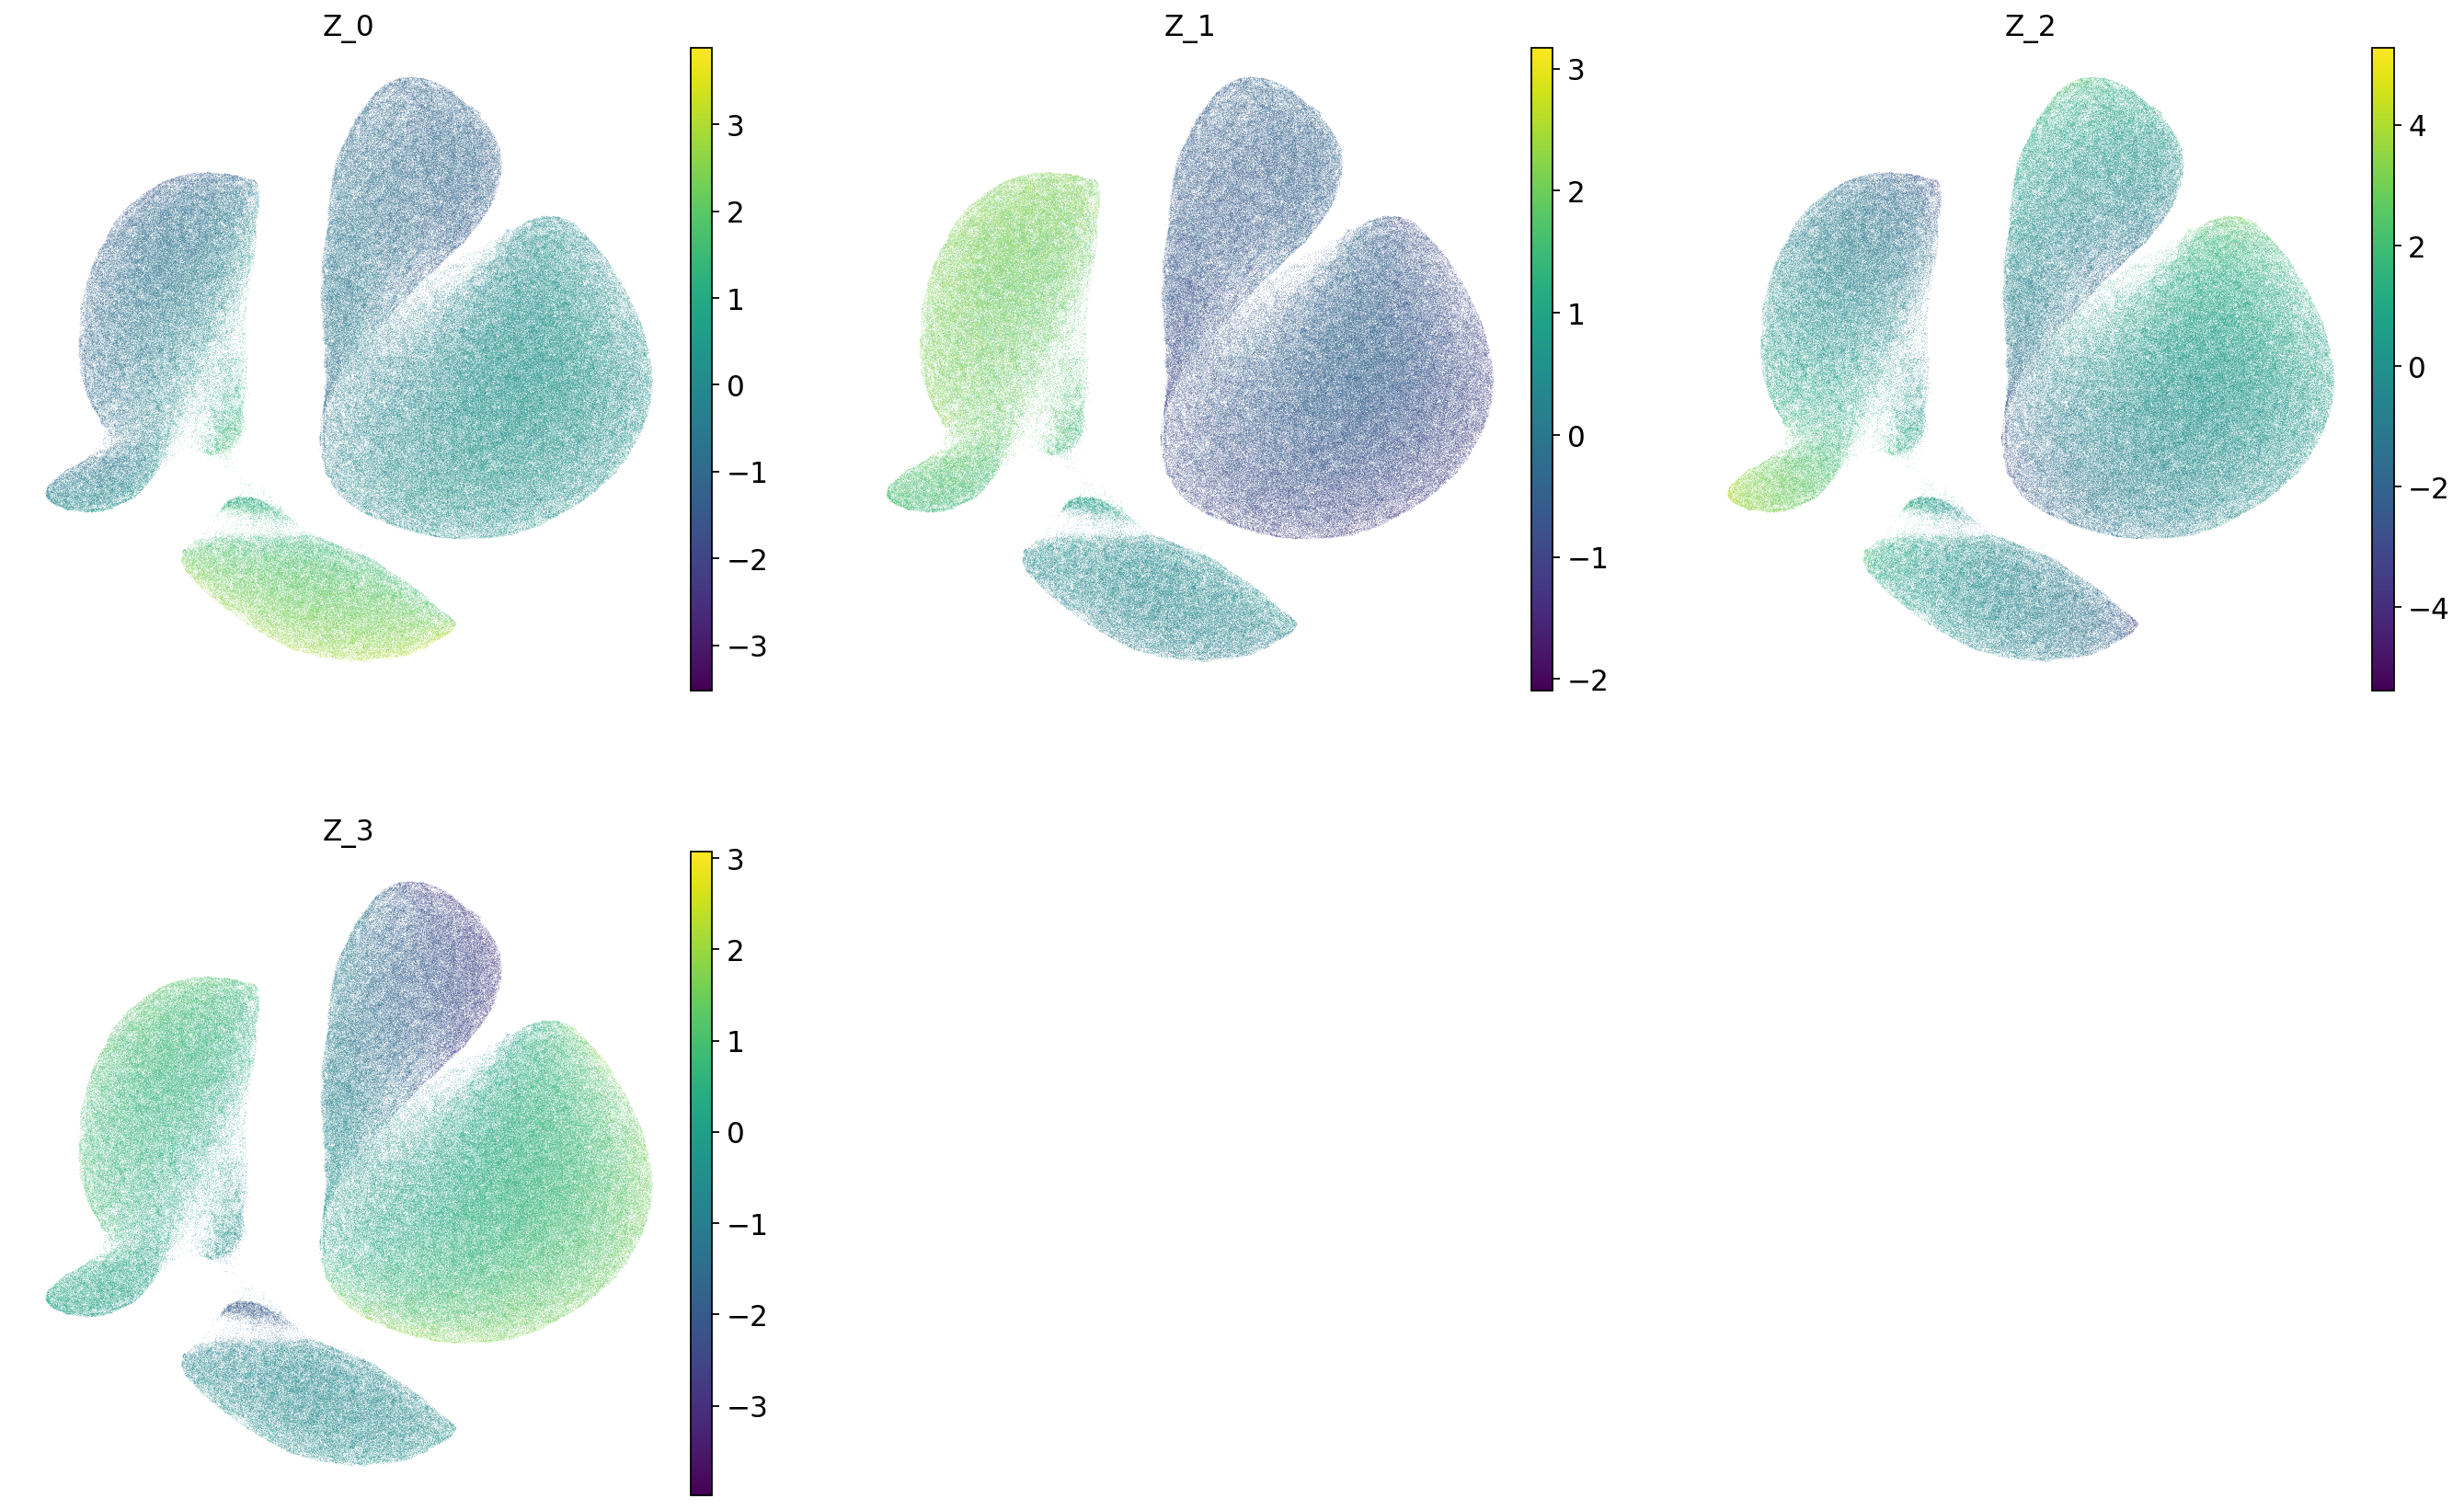

In [17]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat

sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, 
                n_neighbors=20, random_state = random_seed)
sc.tl.umap(adata, min_dist=0.3, random_state = random_seed)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, 
             resolution=0.8, random_state = random_seed)

sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY], 
           save='Perez_1L128H4L_ldVAE_clusters_UMAP.pdf')
sc.pl.umap(adata, color="cg_cov", 
           save='Perez_1L128H4L_ldVAE_UMAP_cg.cov.pdf')
sc.pl.umap(adata, color="ct_cov", 
           save='Perez_1L128H46L_ldVAE_UMAP_ct.cov.pdf')
sc.pl.umap(adata, color="SLE_status", palette="Set1_r", 
           save='Perez_1L128H4L_ldVAE_UMAP_SLE_status.pdf')
           
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3, save='Perez_1L128H4L_ldVAE_expZs_UMAP.pdf')

/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/hbolouri/mambaforge/envs/ldVAE_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


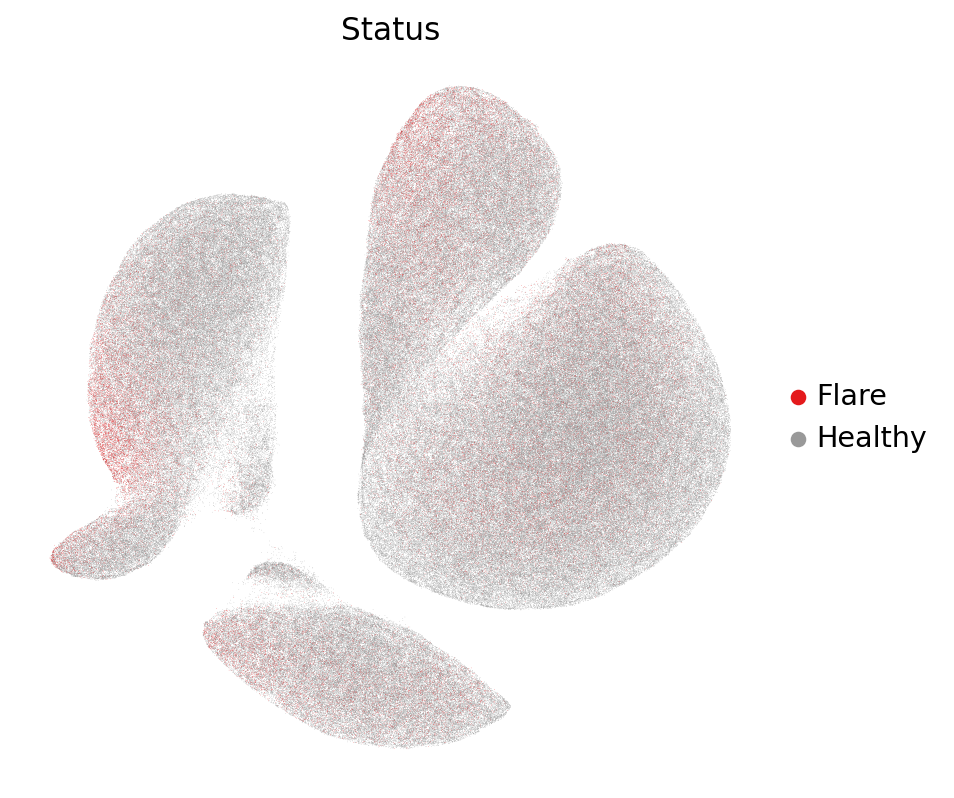

In [18]:
sc.pl.umap(adata, color="Status", palette="Set1", save='Perez_1L128H4L_ldVAE_UMAP_Status.pdf')

In [19]:
adata.obs.groupby('Status').size()

/tmp/user/64103/ipykernel_180774/3390825475.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('Status').size()


Status
Flare       55120
Healthy    486418
dtype: int64

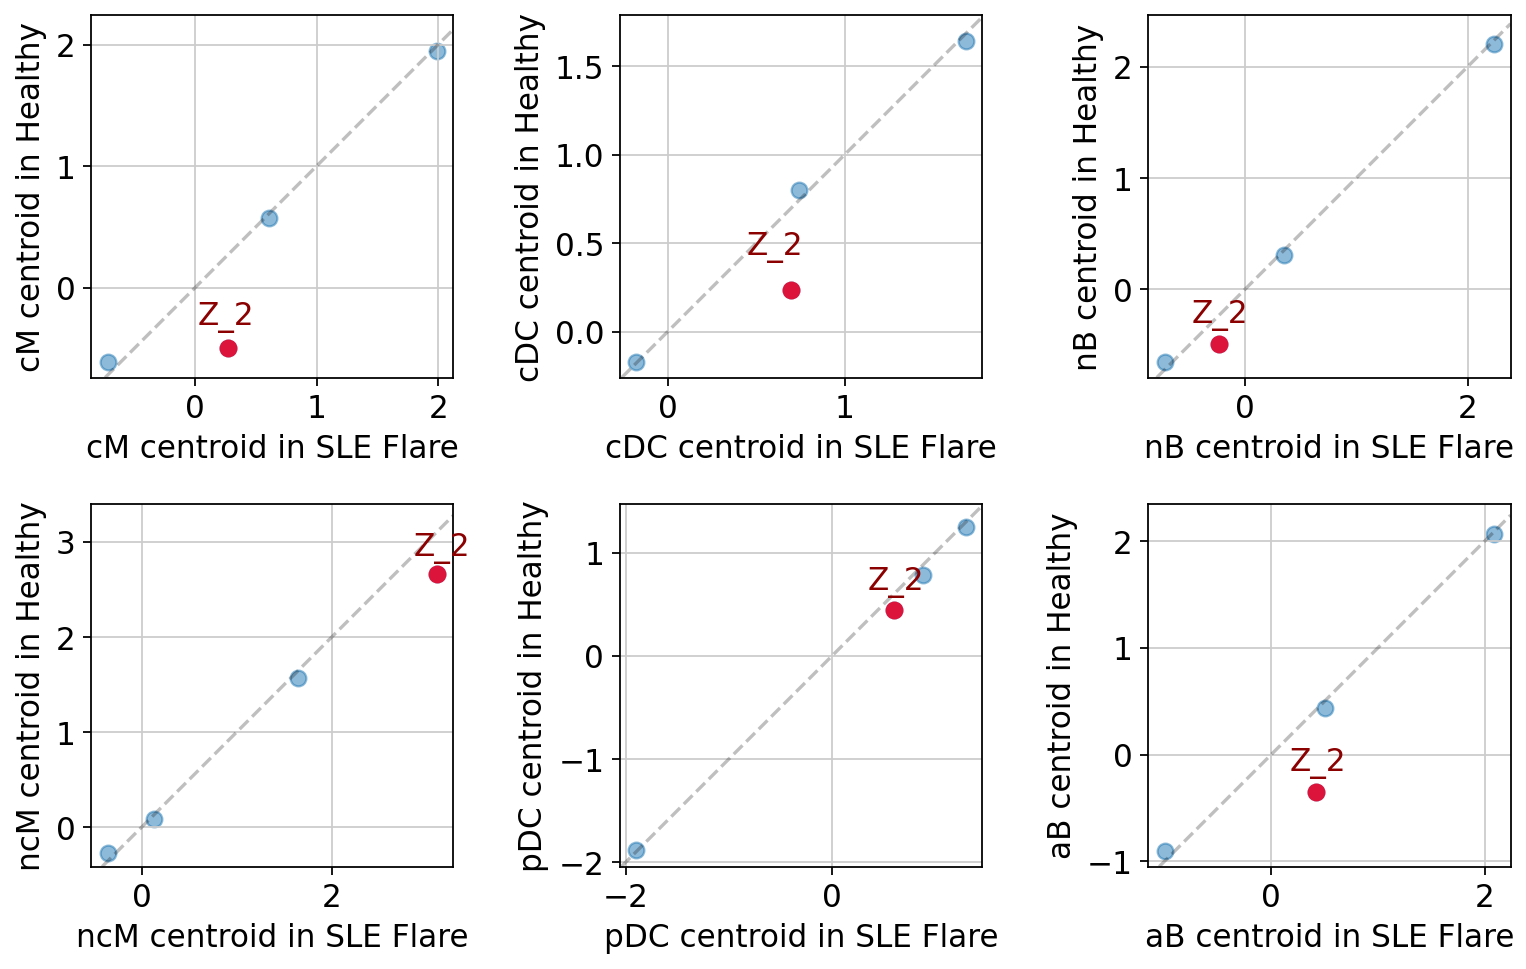

In [20]:
z_labs = ['Z_0', 'Z_1', 'Z_2', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 
          'Z_8', 'Z_9', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14'] 

def z_plt(pop_id, pop_name, ax, pGrp):
    i_pop_SLE = (pGrp == pop_id) & (adata.obs.Status == 'Flare')
    popZ_SLE = Z_hat[i_pop_SLE, :]
    
    i_pop_HD = (pGrp == pop_id) & (adata.obs.Status == 'Healthy')
    popZ_HD = Z_hat[i_pop_HD, :]
    
    centroid_pop_SLE = popZ_SLE.mean(0) # (15,)
    centroid_pop_HD = popZ_HD.mean(0)   # (15,)
    
    ax.scatter(centroid_pop_SLE, centroid_pop_HD, alpha=0.5, s=50)
    ax.set_xlabel(pop_name + " centroid in SLE Flare")
    ax.set_ylabel(pop_name + " centroid in Healthy")
    ax.axis('square')
    ax.axline([-10, -10], [10, 10], alpha = 0.25, 
               color = "black", linestyle='dashed')
    
    i_sel = np.argmax( np.abs(centroid_pop_SLE - centroid_pop_HD) )
    X = centroid_pop_SLE[i_sel]
    Y = centroid_pop_HD[i_sel]
    sel_z = z_labs[i_sel]
    
    ax.annotate(sel_z, xy=[X, Y], xytext=[X-0.25, Y+0.2], color="darkred")
    ax.scatter(X, Y, color="crimson", s=50)

f, ax = plt.subplots(2, 3, figsize=(12, 7))
plt.subplots_adjust(hspace = 0.35)
z_plt(pop_id='cM', pop_name="cM", ax=ax[0, 0], pGrp = adata.obs.cg_cov)
z_plt(pop_id='ncM', pop_name="ncM", ax=ax[1, 0], pGrp = adata.obs.cg_cov)
z_plt(pop_id='cDC', pop_name="cDC", ax=ax[0, 1], pGrp = adata.obs.cg_cov)
z_plt(pop_id='pDC', pop_name="pDC", ax=ax[1, 1], pGrp = adata.obs.cg_cov)
z_plt(pop_id='B_naive', pop_name="nB", ax=ax[0, 2], pGrp = adata.obs.ct_cov)
z_plt(pop_id='B_atypical', pop_name="aB", ax=ax[1, 2], pGrp = adata.obs.ct_cov)
plt.savefig('/mnt/d/scGPT/ldVAE/figures/SLE_v_HD_Zs.pdf', dpi=150)

In [21]:
# type(loadings["Z_5"].sort_values().tail(20))
fPath = "/mnt/d/scGPT/ldVAE/figures/selZ_top50.CSV"

loadings["Z_3"].sort_values().tail(25).to_csv(fPath)
loadings["Z_3"].sort_values().head(25).to_csv(fPath, mode="a")

loadings["Z_2"].sort_values().tail(25).to_csv(fPath, mode="a")
loadings["Z_2"].sort_values().head(25).to_csv(fPath, mode="a")

In [22]:
model.save(dir_path="/mnt/d/ldVAE/ldVAE_Perez_1L128H4L250E")

In [23]:
##########################################################################################################

In [24]:
# RE-START

In [25]:
# adata = scvi.data.read_h5ad("/mnt/d/scGPT/ldVAE/selPerez.h5ad")
# model = scvi.model.LinearSCVI.load("/mnt/d/scGPT/ldVAE/ldVAE_Perez_1L128H6L.250E", 
#                                    adata = adata)